In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(100)
LEVEL = 'level_1'

In [2]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    m=0
    files = os.listdir(folder_path)
    for i, file_name in tqdm(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [3]:
languages = ['ta', 'hi', 'en']
#trainPath = "../input/padhai-text-non-text-classification-level-1/"+LEVEL+"_train/"+LEVEL+"/"
#testPath = "../input/padhai-text-non-text-classification-level-1/"+LEVEL+"_test/kaggle_"+LEVEL
images_train = read_all("../input/padhai-text-non-text-classification-level-1/level_1_train/level_1/"+"background", key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all("../input/padhai-text-non-text-classification-level-1/level_1_train/level_1/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all("../input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_level_1", key_prefix='') # change the path
print(len(images_test))

 14%|█▍        | 63/447 [00:00<00:00, 625.57it/s]

Reading:


  0%|          | 0/149 [00:00<?, ?it/s]

Reading:
Reading:


  0%|          | 0/297 [00:00<?, ?it/s]

Reading:
892
Reading:


100%|██████████| 297/297 [00:00<00:00, 793.80it/s]

297


In [4]:
! cd ../input

In [5]:
list(images_test.keys())[:5]

['170', '234', '287', '87', '167']

In [6]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(892, 256) (892,)
(297, 256)


In [7]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [8]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(np.array(list(loss.values())).astype(float))
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

100%|██████████| 400/400 [00:22<00:00, 17.65epoch/s]


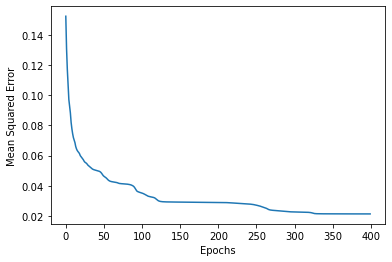

In [9]:
sn_mse = SigmoidNeuron()
sn_mse.fit(X_scaled_train, Y_train, epochs=400, learning_rate=0.015, loss_fn="mse", display_loss=True)

100%|██████████| 100/100 [00:04<00:00, 22.73epoch/s]


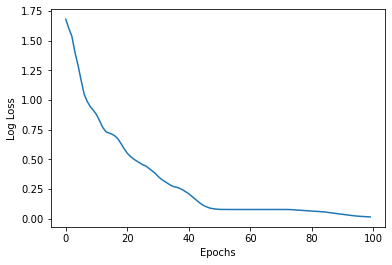

In [10]:
sn_ce = SigmoidNeuron()
sn_ce.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.018, loss_fn="ce", display_loss=True)

In [11]:
def print_accuracy(sn):
  Y_pred_train = sn.predict(X_scaled_train)
  Y_pred_binarised_train = (Y_pred_train >= 0.4).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
  print("Train Accuracy : ", accuracy_train)
  print("-"*50)

In [12]:
print_accuracy(sn_mse)
print_accuracy(sn_ce)

Train Accuracy :  0.9786995515695067
--------------------------------------------------
Train Accuracy :  0.9988789237668162
--------------------------------------------------


## Sample Submission

In [13]:
Y_pred_test = sn_ce.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= 0.4).astype("int").ravel()

submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submission.csv", index=False)

In [14]:
print(submission.head())

     ImageId  Class
272        0      1
172        1      0
72         2      1
221        3      1
255        4      1


In [15]:
df = submission.copy()

In [16]:
df1 = pd.DataFrame({'ImageId':[19,242,286],'Class':[1,0,0]})

In [17]:
df2 = pd.concat([df,df1])

In [18]:
df2.to_csv("submission.csv", index=False)